# Pnevmatikakis 2014 : Greedy Initialization Algorithm

In [1]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
import mpld3

In [2]:
import neuralyzer
from neuralyzer.im import smff

In [3]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (8,8)

In [4]:
datafile = '/Users/michael/coding/RIKEN/data/140316/data5/data2/Image_0001_0001_channel0_13000_14000.tif'
data = neuralyzer.get_data(datafile)

[ 2015-04-13 19:21:17 ] [ log ] [ INFO ] : NEURALYZER LOGGER CREATED
[ 2015-04-13 19:21:17 ] [ log ] [ DEBUG ] : stdoutloglevel: DEBUG
[ 2015-04-13 19:21:17 ] [ data_handler ] [ DEBUG ] : root_path set to /Users/michael/coding/RIKEN/notebooks/dev
[ 2015-04-13 19:21:17 ] [ data_handler ] [ DEBUG ] : loaded data from cache file: /Users/michael/coding/RIKEN/data/140316/data5/data2/Image_0001_0001_channel0_13000_14000.tif.hdf5


In [6]:
print data.dtype
print data.shape
print data[0].shape

uint16
(1000, 512, 512)
(512, 512)


### Mean Image and how the axis lay

In the `numpy array` `data` the axis are as follows:  

`data[time, y, x]`  

therefore, to get the image at time `t` i can simply do:

`data[t]`

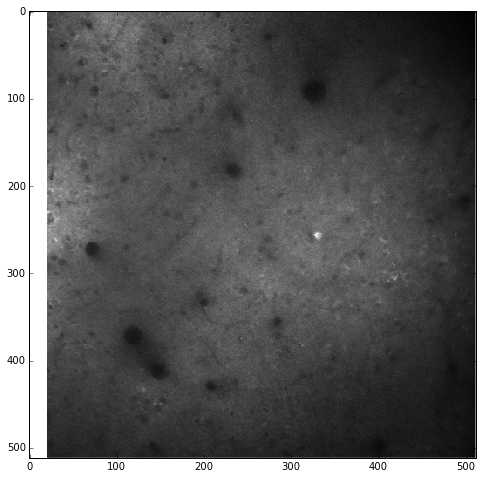

In [6]:
mean = data.mean(axis=0)
# creating a white stripe of 20 pixels width along the first axis!!
mean[:,:20] = mean.max()
plt.imshow(mean)

### reshape the data

In [6]:
datashape = data.shape
data = data.reshape((data.shape[0], data.shape[1]*data.shape[2])).T
data.shape

(262144, 1000)

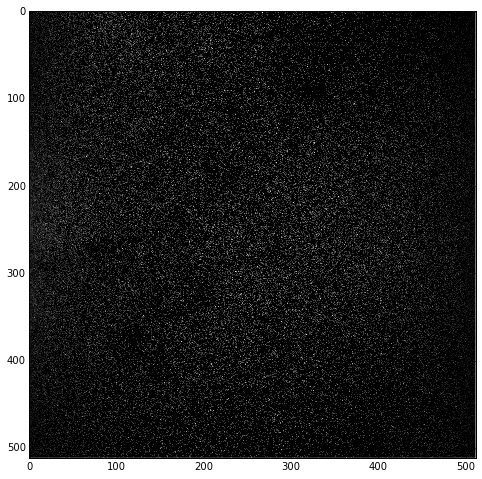

In [7]:
# image at timepoint 0
plt.imshow(data[:,0].reshape((512, 512)))

### centering the data

In [8]:
def center_data(data, method='mean'):
    if method == 'mean':
        return data - np.array(data.shape[1]*[data.mean(axis=1)]).T
    elif method == 'median':
        return data - np.array(data.shape[1]*[np.median(data,axis=1)]).T
    else:
        raise ValueError('Method "%s" not available for data centering.')

In [11]:
mean_centered = center_data(data, method='mean')
median_centered = center_data(data, method='median')

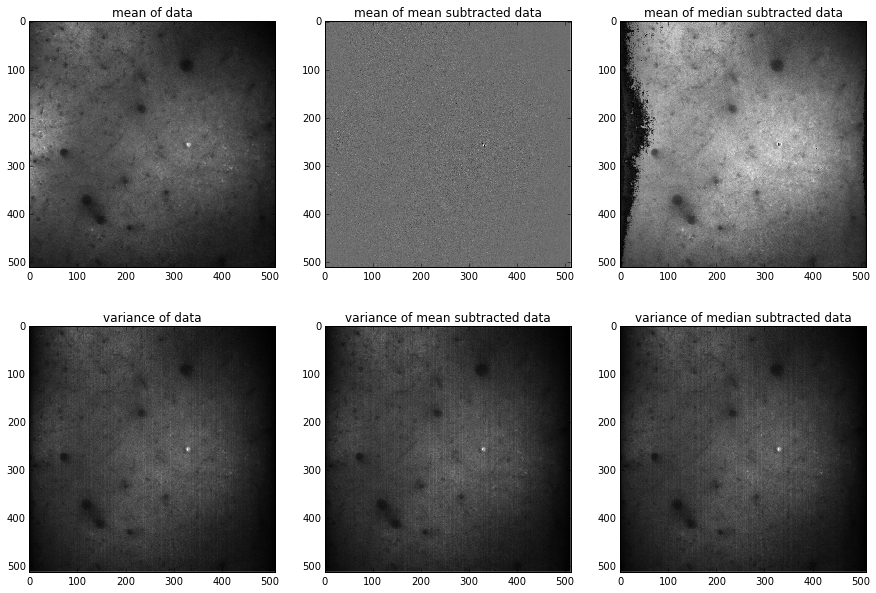

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
ax[0][0].imshow(data.mean(axis=1).reshape((512,512)))
ax[0][0].set_title('mean of data')
ax[0][1].imshow(mean_centered.mean(axis=1).reshape((512,512)))
ax[0][1].set_title('mean of mean subtracted data')
ax[0][2].imshow(median_centered.mean(axis=1).reshape((512,512)))
ax[0][2].set_title('mean of median subtracted data')
ax[1][0].imshow(data.var(axis=1).reshape((512,512)))
ax[1][0].set_title('variance of data')
ax[1][1].imshow(mean_centered.var(axis=1).reshape((512,512)))
ax[1][1].set_title('variance of mean subtracted data')
ax[1][2].imshow(median_centered.var(axis=1).reshape((512,512)))
ax[1][2].set_title('variance of median subtracted data')

## Gaussian Kernel

In [9]:
def gauss_kernel(size, var=None):    
    if type(size) == int:
        size = (size, size)
    else:
        raise ValueError('We only provide symmetric kernels with sizes specified by an int.')
    if not np.mod(size[0],2) or not np.mod(size[1],2):
        raise ValueError('The size of the Kernel has to be odd.')
    s = (int(size[0]/2.), int(size[0]/2.))
    if var is None: v = s
    elif type(var) == int: v = (var, var)
    else: v = var
    x, y = np.mgrid[-s[0]:s[0]+1, -s[1]:s[1]+1]
    g = np.exp(-(x**2/(2*float(v[0]))+y**2/(2*float(v[1]))))
    return g / g.sum()

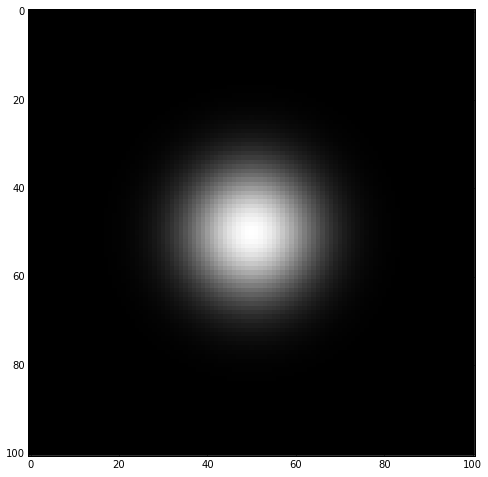

In [10]:
size = 101
g = gauss_kernel(size, size)
plt.imshow(g)

In [11]:
def gaussian_blur_matrix(dim, kernelsize, kernelvariance):
    from scipy import sparse
    kernel = gauss_kernel(kernelsize, kernelvariance).flatten()
    kl = len(kernel)
    D = np.zeros((dim, dim+kl-1))
    for idx in range(dim):
        D[idx,idx:idx+kl] = kernel
    D = D[:,((kl-1)/2):-(kl-1)/2]
    return sparse.dia_matrix(D.T)

In [12]:
data.shape

(262144, 1000)

In [ ]:
D = gaussian_blur_matrix(data.shape[0], 41, 20)

In [13]:
D.shape

(262144, 262144)

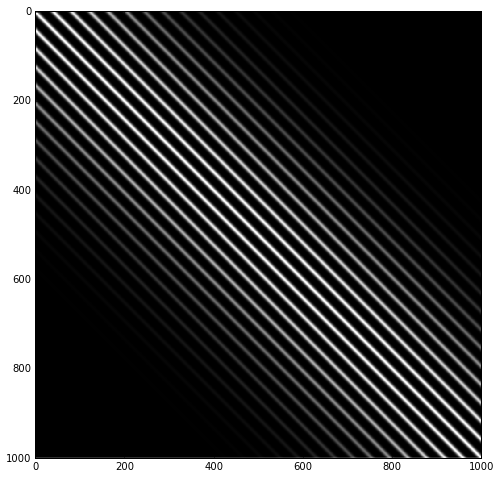

In [20]:
plt.imshow(D[:1000, :1000])

In [8]:
data.shape

(262144, 1000)

In [22]:
def greedy_neuron_id(Y, K, tau, w):
    med = np.median(Y, axis=1)
    MED = np.array(Y.shape[0]*[med])
    Y = Y - MED
    R = Y.copy()
    D = gaussian_blur_matrix(Y.shape[0], w, tau)
    for i in range(K):
        rho = np.dot(D.T, R)
        v = 

In [7]:
D = smff.gaussian_blur_matrix_sparse(data.shape[0], 41, 20)

In [10]:
Y = data.copy()
med = np.median(Y, axis=1)
MED = np.array(Y.shape[1]*[med]).T
Y = Y - MED
R = Y.copy()

In [11]:
R.shape

(262144, 1000)

In [ ]:
rho = np.dot(D,data)

In [10]:
rho.shape

(262144, 1000)

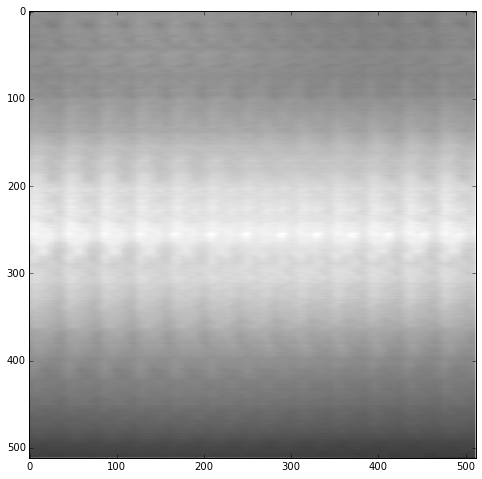

In [14]:
plt.imshow(rho.mean(axis=1).reshape(512,512))

In [15]:
a = np.array([[1,2,],[3,4,]])
b = np.array([[10,20,],[30,40,]])

In [16]:
a

array([[1, 2],
       [3, 4]])

In [17]:
b

array([[10, 20],
       [30, 40]])

In [19]:
np.dot(a,b)

array([[ 70, 100],
       [150, 220]])

In [16]:
D.size

68719476736

In [15]:
from scipy import sparse

In [21]:
sparse.coo_matrix?

In [22]:
sparse.dia_matrix?

In [ ]:
Ds = sparse.dia_matrix(D)